In [1]:
import cv2
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

### Dataset: https://www.kaggle.com/tongpython/cat-and-dog

In [2]:
TRAIN_PATH = './cats_and_dogs/training_set/'
TEST_PATH = './cats_and_dogs/test_set/'

In [3]:
CLASSES = ('Cat', 'Dog')

In [4]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (192, 192))
    image = tf.image.rgb_to_grayscale(image) 
    image /= 255.0
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [5]:
def load_dataset(path):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = 32
    def get_label(file_path: str) -> int:
        if 'cat' in file_path.rsplit('/', maxsplit=1)[-1]:
            return 0
        return 1
    
    data_paths = []
    data_labels = []
    
    
    for item in Path(path).glob('**/*'):
        if item.is_file() and str(item).endswith('.jpg'):
            data_paths.append(str(item))
            data_labels.append(get_label(str(item)))
    path_ds = tf.data.Dataset.from_tensor_slices(data_paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(data_labels, tf.int64))
    ds = tf.data.Dataset.zip((image_ds, label_ds))
    
    ds = ds.shuffle(buffer_size=len(data_paths)).batch(BATCH_SIZE)
    
    return ds

In [6]:
train_ds = load_dataset(TRAIN_PATH)
test_ds = load_dataset(TEST_PATH)

In [7]:
tf.keras.backend.clear_session() 
model = tf.keras.Sequential( [
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation=tf.nn.leaky_relu, input_shape=(192,192,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=tf.nn.leaky_relu),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(units=64, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 188, 188, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       7

In [9]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

In [10]:
model.fit(train_ds, epochs=10, verbose=2)

Epoch 1/10


W0624 23:21:32.755701 139935907284800 deprecation.py:323] From /media/dracoboros/HDD/main/tensorflow2beta/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


251/251 - 10s - loss: 0.6805 - sparse_categorical_accuracy: 0.5755
Epoch 2/10
251/251 - 8s - loss: 0.5997 - sparse_categorical_accuracy: 0.6831
Epoch 3/10
251/251 - 8s - loss: 0.5176 - sparse_categorical_accuracy: 0.7449
Epoch 4/10
251/251 - 8s - loss: 0.4267 - sparse_categorical_accuracy: 0.7958
Epoch 5/10
251/251 - 8s - loss: 0.3362 - sparse_categorical_accuracy: 0.8530
Epoch 6/10
251/251 - 8s - loss: 0.2881 - sparse_categorical_accuracy: 0.8776
Epoch 7/10
251/251 - 8s - loss: 0.1954 - sparse_categorical_accuracy: 0.9237
Epoch 8/10
251/251 - 8s - loss: 0.1294 - sparse_categorical_accuracy: 0.9489
Epoch 9/10
251/251 - 8s - loss: 0.1042 - sparse_categorical_accuracy: 0.9626
Epoch 10/10
251/251 - 8s - loss: 0.1504 - sparse_categorical_accuracy: 0.9464


In [11]:
model.evaluate(test_ds)

64/64 [==============================] - 1s 18ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.7212


[1.2013170160353184, 0.7212061]

In [12]:
def predict(model, image_path):
    ret = model(tf.reshape(load_and_preprocess_image(image_path), (-1, 192, 192, 1))).numpy()
    print(f"Cat: {ret[0][0] * 100}")
    print(f"Dog: {ret[0][1] * 100}")
    return CLASSES[np.argmax(ret)]
    

Cat: 9.679188579320908
Dog: 90.32081365585327
Result: Dog


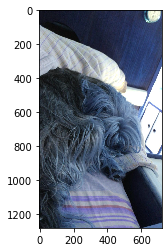

In [13]:
plt.imshow(cv2.imread('./test_dog_1.jpg'))
print("Result:",predict(model, './test_dog_1.jpg'))

Cat: 42.20039248466492
Dog: 57.79960751533508
Result: Dog


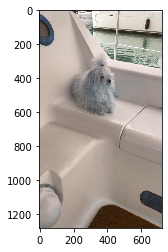

In [14]:
plt.imshow(cv2.imread('./test_dog_2.jpg'))
print("Result:",predict(model, './test_dog_2.jpg'))

Cat: 88.20600509643555
Dog: 11.79400086402893
Result: Cat


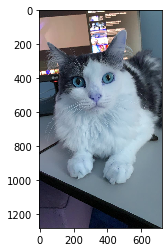

In [15]:
plt.imshow(cv2.imread('./test_cat_1.jpg'))
print("Result:",predict(model, './test_cat_1.jpg'))

Cat: 1.8161483108997345
Dog: 98.18384647369385
Result: Dog


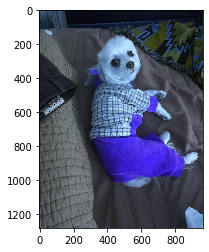

In [16]:
plt.imshow(cv2.imread('./test_dog_pants.jpg'))
print("Result:",predict(model, './test_dog_pants.jpg'))

Cat: 99.99641180038452
Dog: 0.003592572102206759
Result: Cat


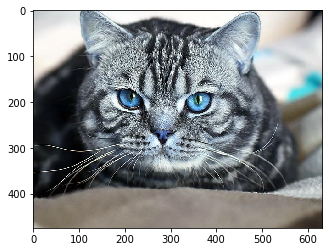

In [17]:
plt.imshow(cv2.imread('./test_cat_2.jpg'))
print("Result:",predict(model, './test_cat_2.jpg'))

Cat: 98.48666787147522
Dog: 1.5133299864828587
Result: Cat


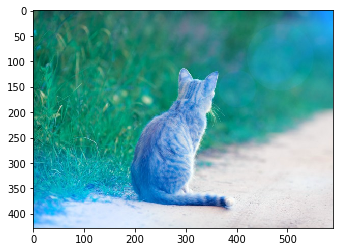

In [18]:
plt.imshow(cv2.imread('./test_cat_3.jpg'))
print("Result:",predict(model, './test_cat_3.jpg'))

In [22]:
model.save_weights('weights/cats_dogs_v3.ckpt')

In [23]:
model.save('cats_dogs_v3.h5')